In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers datasets torchaudio librosa evaluate jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.2 MB/s eta 0:00:00


# Pre-preprocessing

Before running this notebook, I removed all mp3 files above 40kb inside the train set. This is done to preserve some space within Google Drive as well as alleviate some of the RAM usage during preprocessing & training. Furthermore, long input sequences require a lot of memory. Since Wav2Vec2 is based on self-attention, the memory requirement scales quadratically with the input length for long input sequences. Randomly peeking mp3 files of size 40kb seems to mostly be at 5 seconds long.

# Prepare Data, Processor (Tokenizer + Feature Extracter)

Will be running cv-train-2a on Google Colab due to lack of compute on my end.
Due to lack of time + compute, I will also be further limiting the mp3 files to 10,000 for training & validation.<br>

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text. For HuggingFace Wav2Vec2, we can use a processer that functions as both tokenizer & feature extracter





In [2]:
import pandas as pd
from datasets import load_dataset
from datasets import Dataset, Audio


In [3]:
csv_path = "/content/drive/MyDrive/notebooks/HTX/cv-valid-train/cv-valid-train.csv"
audio_dir = "/content/drive/MyDrive/notebooks/HTX/cv-valid-train/cv-valid-train/"

import pandas as pd
from datasets import Dataset

df = pd.read_csv(csv_path)



In [4]:
df.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [5]:
#check for existance of special characters in the text
df['has_special_char'] = df['text'].apply(lambda x: any(c in x for c in ['!', '?', '.', ',', ':', ';', '-', '_', '(', ')', '[', ']', '{', '}', '"', '@', '#', '$', '%', '^', '&', '*']))
df['has_special_char'] = df['has_special_char'].astype(int)

df.query("has_special_char == 1").head()



,filename,text,up_votes,down_votes,age,gender,accent,duration,has_special_char


In [6]:
# drop has_special_char
df = df.drop(columns=['has_special_char'])

I will calculate the downvote ratio (```num_down_votes/total_votes```) and only keep rows where the ratio is below 0.3. This lazily ensures that the text corresponds the audio. <br>

I will then convert all the text to uppercase since the tokenizer expects Uppercase letters

In [7]:
# calculat downvote ratio
df['down_votes'] = df['down_votes'] + 0.001
df['down_votes_ratio'] = df['down_votes'] / (df['up_votes'] + df['down_votes'])

print(f"shape before {df.shape}")

df = df[df['down_votes_ratio'] < 0.3]

print(f"shape after {df.shape}")

#convert text to upper, wav2vec2 expects captial letters for tokens
df['text'] = df['text'].str.upper()

shape before (195776, 9)
shape after (184911, 9)


In [8]:
# ensure that files in the df are accounted; else drop
import os

def check_file_exists(filename):
    return os.path.exists(os.path.join(audio_dir, filename))

#df = df[df['filename'].apply(check_file_exists)]
print(f"shape after {df.shape}")
#df.to_csv("/content/drive/MyDrive/notebooks/HTX/cv-valid-train/cv-valid-train-limited.csv", index=False)

shape after (184911, 9)


In [9]:
df = pd.read_csv("/content/drive/MyDrive/notebooks/HTX/cv-valid-train/cv-valid-train-limited.csv")

In [10]:
# resample with 10,000 files; due to lack of compute
if len(df) > 15000:
  df = df.sample(n=10000, random_state=42)

In [11]:
df.shape

(10000, 9)

Wav2Vec2Processor acts as boths feature extractor and tokenizer. Wav2Vec2FeatureExtractor (for input audio)
Wav2Vec2CTCTokenizer (for transcript labels)

Observing the tokenizer's vocab list, our text should have no issues.

In [12]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [13]:
#check processor vocab
processor.tokenizer.get_vocab()

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 'E': 5,
 'T': 6,
 'A': 7,
 'O': 8,
 'N': 9,
 'I': 10,
 'H': 11,
 'S': 12,
 'R': 13,
 'D': 14,
 'L': 15,
 'U': 16,
 'M': 17,
 'W': 18,
 'C': 19,
 'F': 20,
 'G': 21,
 'Y': 22,
 'P': 23,
 'B': 24,
 'V': 25,
 'K': 26,
 "'": 27,
 'X': 28,
 'J': 29,
 'Q': 30,
 'Z': 31}

## Step 1: Load and normalise audio
Resampling to 16kHz is necessary because wav2vec2-large-960h was pretrained on 16kHz audio. I am using the inbuilt Audio library in Datasets to perform resampling. this maintains aintains compatibility with wav2vec2-large-960h &ensures consistent waveform shape and sampling across dataset

In [14]:
dataset = Dataset.from_pandas(df)

dataset = dataset.remove_columns(["down_votes", "up_votes", "down_votes_ratio", "age","gender","accent","duration"])

#map full audio path
def map_path(example):
  example["audio"] = audio_dir + example["filename"]
  return example


dataset = dataset.map(map_path)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [16]:
# check
dataset[0]['audio']

{'path': '/content/drive/MyDrive/notebooks/HTX/cv-valid-train/cv-valid-train/cv-valid-train/sample-059036.mp3',
 'array': array([-5.09317033e-11, -7.27595761e-12, -5.45696821e-11, ...,
         3.65374610e-03,  7.22027570e-03,  4.03120741e-03]),
 'sampling_rate': 16000}

## Step 2: Tokenize audio and transcript
1. we convert the raw audio tensor into input tensors for the model (via feature extractor class) <br>
2. we also encode the text into seq of token ids (via tokenizer class)


In [20]:
# should probably batch this for faster processing
def preprocess(example):
    example["input_values"] = processor.feature_extractor(example["audio"]["array"], sampling_rate=example["audio"]["sampling_rate"]).input_values[0]

    example["labels"] = processor.tokenizer(text = example["text"]).input_ids
    return example

def preprocess_batch(batch):
    audio = batch["audio"]
    input_values = processor.feature_extractor(
        [a["array"] for a in audio],
        sampling_rate=audio[0]["sampling_rate"]  # all same sampling rate
    ).input_values
    batch["input_values"] = input_values

    batch["labels"] = processor.tokenizer(text = batch["text"]).input_ids
    return batch

dataset = dataset.map(preprocess, remove_columns=dataset.column_names)
#dataset = dataset.map(preprocess_batch, remove_columns=dataset.column_names["train"], batched = True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [22]:
# save dataset
dataset.save_to_disk("/content/drive/MyDrive/notebooks/HTX/processed-data")

Saving the dataset (0/4 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

# Training

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import datasets
dataset = datasets.load_from_disk("/content/drive/MyDrive/notebooks/HTX/processed-data")

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
dataset = dataset.train_test_split(test_size=0.3, seed = 42)

In [4]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [5]:
# check if my tokenizer encoding is properly set up
processor.tokenizer.decode(dataset['train'][0]['labels'])

"IT'S GOD TO SE YOU"

In [6]:
# import model
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

model.freeze_feature_encoder()
model.gradient_checkpointing_enable()

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# create data collator for feeding data into Trainer

import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:


    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels_batch["input_ids"]

        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


In [8]:
#test data collator
input = data_collator([dataset['train'][0]])
print(input.keys())

dict_keys(['input_values', 'labels'])


/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [9]:
input['input_values']

tensor([[-0.0044, -0.0044, -0.0044,  ..., -0.0045, -0.0044, -0.0043]])

In [10]:
# decode back values
print(processor.decode(input['labels'][0]))

IT'S GOD TO SE YOU


In [21]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
  output_dir="/content/model",
  eval_strategy="steps",
  per_device_train_batch_size=4,
  gradient_accumulation_steps=4, #Simulates larger batch
  learning_rate=3e-5, #Conservative for ASR fine-tuning
  eval_steps = 400,
  save_steps = 400,
  num_train_epochs= 5,
  save_total_limit = 1,
  logging_dir = "/content/logs",
  logging_steps = 10,
  fp16=True,
  group_by_length=True, # avoids padding
  gradient_checkpointing=True, # prevents OOM
  warmup_ratio= 0.1,
  metric_for_best_model = "wer",
  load_best_model_at_end= True,
  report_to = "none"
)

In [12]:
!pip install jiwer evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 1.5 MB/s eta 0:00:00


In [ ]:
# get wer metrics for compute metrics

import evaluate

def compute_metrics(pred):
    wer = evaluate.load("wer")
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

import numpy as np

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-22-2898785830.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
400,26.711900,136.912186,0.192486
800,38.329500,94.842018,0.288907
1200,2.011800,191.561966,0.138115
1600,-4.227200,202.016464,0.119126
2000,10.728300,121.064667,0.157613


/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

TrainOutput(global_step=2190, training_loss=34.05615050041512, metrics={'train_runtime': 4167.0358, 'train_samples_per_second': 8.399, 'train_steps_per_second': 0.526, 'total_flos': 3.066877345654702e+18, 'train_loss': 34.05615050041512, 'epoch': 5.0})

In [23]:
trainer.save_model("/content/drive/MyDrive/notebooks/HTX/wav2vec2-large-960h-cv")

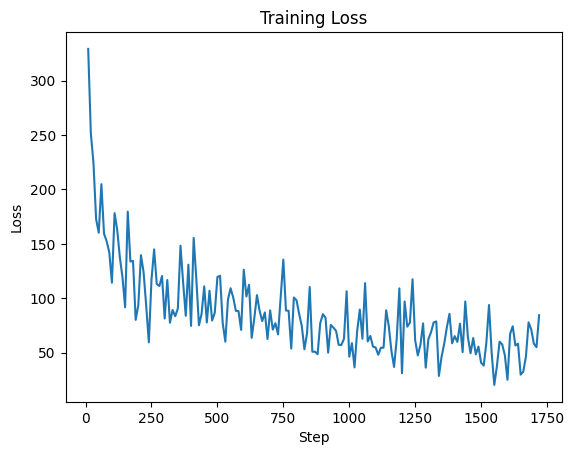

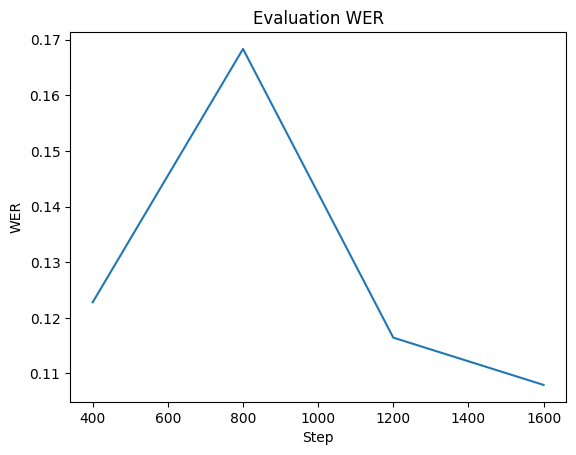

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
df = pd.DataFrame(log_history)

# Plot loss
plt.plot(df[df["loss"].notna()]["step"], df[df["loss"].notna()]["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Plot WER
plt.plot(df[df["eval_wer"].notna()]["step"], df[df["eval_wer"].notna()]["eval_wer"])
plt.xlabel("Step")
plt.ylabel("WER")
plt.title("Evaluation WER")
plt.show()


# Inference on valid cv-valid-test

In [20]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# load model and processor
model = Wav2Vec2ForCTC.from_pretrained("./asr_train/wav2vec2-large-960h-cv")
processor = Wav2Vec2Processor.from_pretrained("./asr_train/wav2vec2-large-960h-cv")


In [21]:
import pandas as pd
import os
import torch
import torchaudio
AUDIO_DIR = "./data/common_voice/cv-valid-test"
CSV_PATH = "./asr_train/cv-valid-test.csv"


In [23]:
cv_valid_test_df = pd.read_csv(CSV_PATH)
# Add a new column for the generated text
generated = []

print(f"Processing {len(cv_valid_test_df)} files...")

# Loop through each row
for idx, row in cv_valid_test_df.iterrows():
    filename = row["filename"]
    audio_path = os.path.join(AUDIO_DIR, filename)

    # load and convert to 16kHz mono
    waveform, sample_rate = torchaudio.load(audio_path)

    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        sample_rate = 16000

    # get inputs
    inputs = processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt", padding=True)

    # perform inference
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])

    generated.append(transcription)

# Add to DataFrame and save
cv_valid_test_df["generated_text"] = generated
cv_valid_test_df.to_csv(CSV_PATH, index=False)

print(f"\nDone. Transcriptions saved to: {CSV_PATH}")

Processing 3995 files...

Done. Transcriptions saved to: ./asr_train/cv-valid-test.csv


In [26]:
# calculate WER
import evaluate
wer = evaluate.load("wer")

cv_valid_test_df = cv_valid_test_df.dropna(subset=['generated_text'])

results = wer.compute(predictions=cv_valid_test_df['generated_text'].tolist(), references=cv_valid_test_df['text'].tolist())

print(f"WER: {results:.4f}")


WER: 1.0053
